In [1]:
#pip install https://github.com/stefanloock/pyshearlab/archive/master.zip

# Tutorial Part 1: play with direct model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy
import scipy.io


from numba import jit
import pylops
from Tools.wavelet_utils import *
from Tools.measurement_tools import *
from Tools.tools import *

## 1- Load image 

Display original image size:
(321, 481)


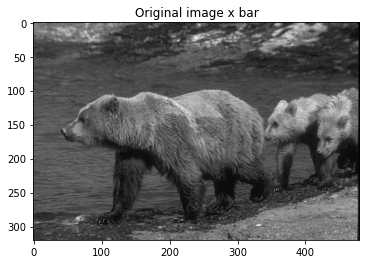

In [3]:
# load image (RGB and convert to grayscale)
im = Image.open('images/bears.jpg').convert('L')
xtrue = np.array(im) 
xtrue = xtrue / xtrue.max()

print("Display original image size:")
print(xtrue.shape)
# convert to even size
if xtrue.shape[0]%2 == 1:
    xtrue = xtrue[:-1,...]
if xtrue.shape[1]%2 == 1:
    xtrue = xtrue[...,:-1]

nx, ny = xtrue.shape
imshowgray(xtrue, 'Original image x bar')

## 2-Convolution operators

We first focus on convolution operators that are typically encountered in microscopy imagery or high-contrast polarimetric imagery.

### 2.1 - Define convolution operator

Several kernel are provided in the repository "blur_models". 

You can change them in order to evaluate the impact on the degraded data. 

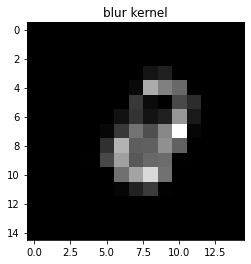

In [4]:
pth_kernel='blur_models/blur_3.mat'
h = scipy.io.loadmat(pth_kernel)
h = np.array(h['blur'])
imshowgray(h, 'blur kernel')

The next step define the operators $\Phi$ and $\Phi^*$ from the filter. Cf. Part 1-a of the course.

In [5]:
Phi, Phit = get_operators(type_op='deconvolution', pth_kernel=pth_kernel)


### 2.2 - Define operator from filter and check adjoint 

To insure the convergence of the reconstruction algorithms, it is necessary to insure the correct implementation of the adjoint. To do so, the following code check the equality:
$$
\langle x, \Phi y \rangle = \langle \Phi^* x, y \rangle
$$

In [6]:
test_adj = True
if test_adj is True:
    print('Test adjointness of operator')
    xtmp = np.random.rand(*xtrue.shape)
    Phixtmp = Phi(xtmp)
    ytmp = np.random.rand(*Phixtmp.shape)
    Phitytmp = Phit(ytmp)
    print('x shape: ', xtmp.shape)
    print('y shape: ', ytmp.shape)
    print('Phi(x) shape: ', Phixtmp.shape)
    print('Phit(y) shape: ', Phitytmp.shape)
    fwd = np.sum(xtmp.flatten()*Phitytmp.flatten())
    bwd = np.sum(Phixtmp.flatten()*ytmp.flatten())
    print('forward: ', fwd)
    print('backward: ', bwd)
    print('-----------------------------')
   

Test adjointness of operator
x shape:  (320, 480)
y shape:  (320, 480)
Phi(x) shape:  (320, 480)
Phit(y) shape:  (320, 480)
forward:  38506.82656029065
backward:  38506.82656029066
-----------------------------


### 2.3 - Power method to compute $\Vert \Phi \Vert^2$

Most of the proximal algorithms require the knowledge of  $\Vert \Phi \Vert^2$ to insure the convergence of the iterates. To do so, the power method is generally implemented.

In [7]:
b0  = np.random.random([nx,ny])
N  = 25
beta = 0
for i in range(N):
    bk = Phit(Phi(b0))
    lambda0 = np.linalg.norm(bk, 2) / np.linalg.norm(b0, 2)
    b0 = bk
    
LipPhi = lambda0
print('Norm squared of the direct operator:')
print(lambda0)

Norm squared of the direct operator:
0.9999996374535206


### 2.4 - Degraded data

In this section we now create a blurry and noisy image of the form:
$$
z = \Phi \overline{x} + \epsilon
$$
where $\epsilon\sim \mathcal{N}(0,\sigma^2\mathbb{I})$.
You can evalute the impact of the choice of the variance of the noise $\sigma^2$ by changing the value "std".

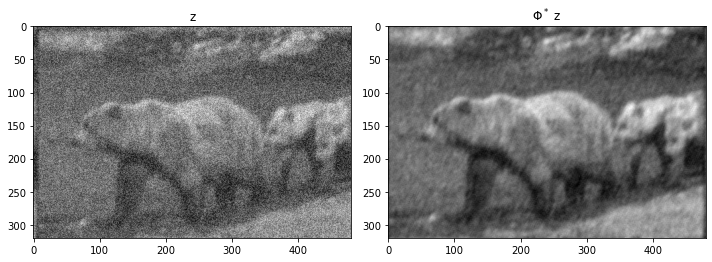

In [8]:
x_blurred = Phi(xtrue)
nxb, nyb = x_blurred.shape
std = 0.5
z = x_blurred+std*np.random.rand(nxb,nyb) 
xrec =  Phit(z)
xrec = xrec.reshape(nx, ny)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(z.reshape(nxb, nyb), cmap="gray")
axs[0].set_title("z")
axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z")
fig.tight_layout()

## 3 - Tomography operator

Let's start by loading the Shepp-Logan phantom model. We can then construct
the sinogram by providing a custom-made function to the
:func:`pylops.signalprocessing.Radon2D` that samples parametric curves of
such a type:

\begin{align}t(r,\theta; x) = \tan(90°-\theta)x + \frac{r}{\sin(\theta)}\end{align}

where $\theta$ is the angle between the x-axis ($x$) and
the perpendicular to the summation line and $r$ is the distance
from the origin of the summation line.

Display original image size:
(225, 225)


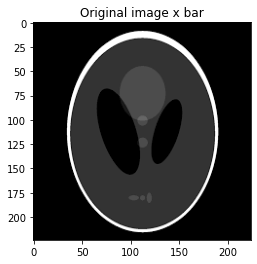

In [9]:
im = Image.open('images/shepp_logan_phantom.png').convert('L')
xtrue = np.array(im) 
xtrue = xtrue / xtrue.max()

print("Display original image size:")
print(xtrue.shape)
# convert to even size
if xtrue.shape[0]%2 == 1:
    xtrue = xtrue[:-1,...]
if xtrue.shape[1]%2 == 1:
    xtrue = xtrue[...,:-1]

nx, ny = xtrue.shape
imshowgray(xtrue, 'Original image x bar')

### 3.1 - Define tomography operator and check adjoint

You can change the value of "ntheta" and see the impact on the create sinogram.

In [10]:
ntheta = 150
Phi, Phit = get_operators_tomo2(type_op='tomography', ntheta = ntheta, nx=nx, ny=ny)

In [11]:
test_adj = True
if test_adj is True:
    print('Test adjointness of operator')
    xtmp = np.random.rand(*xtrue.shape)
    print(xtmp.shape)
    Phixtmp = Phi(xtmp)
    ytmp = np.random.rand(*Phixtmp.shape)
    Phitytmp = Phit(ytmp)
    print('x shape: ', xtmp.shape)
    print('y shape: ', ytmp.shape)
    print('Phi(x) shape: ', Phixtmp.shape)
    print('Phit(y) shape: ', Phitytmp.shape)
    fwd = np.sum(xtmp.flatten()*Phitytmp.flatten())
    bwd = np.sum(Phixtmp.flatten()*ytmp.flatten())
    print('forward: ', fwd)
    print('backward: ', bwd)
    print('-----------------------------')

Test adjointness of operator
(224, 224)
x shape:  (224, 224)
y shape:  (33600,)
Phi(x) shape:  (33600,)
Phit(y) shape:  (224, 224)
forward:  8893.410886171925
backward:  8893.410886171927
-----------------------------


### 3.2 - Power method to compute $\Vert \Phi \Vert^2$

In [12]:
nx, ny = xtrue.shape
b0  = np.random.random([nx,ny])
N  = 25
beta = 0
for i in range(N):
    bk = Phit(Phi(b0))
    lambda0 = np.linalg.norm(bk, 2) / np.linalg.norm(b0, 2)
    b0 = bk

LipPhi = lambda0
print('Norm squared of the direct operator:')
print(lambda0)

# function implemented in Tools/tools.py to compute the spectral norm (as above but embeded in tools.py)
normPhi2 = op_norm2(Phi, Phit, xtrue.shape)
print(normPhi2)

Norm squared of the direct operator:
1.000000000001209
0.9999927907780919


### 3.3 - Degraded data

In this section we now create a blurry and noisy image of the form:
$$
z = \Phi \overline{x} + \epsilon
$$
where $\epsilon\sim \mathcal{N}(0,\sigma^2\mathbb{I})$.
You can evalute the impact of the choice of the variance of the noise $\sigma^2$ by changing the value "std".

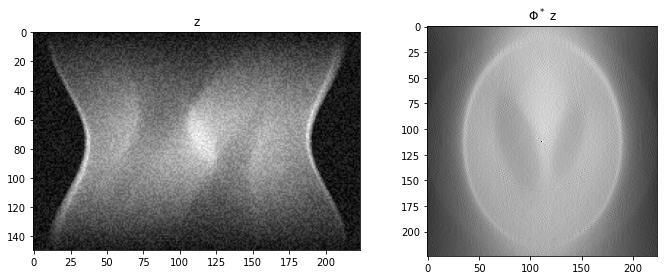

In [13]:
x_tomo = Phi(xtrue)
std = 0.1
z = x_tomo+std*np.random.rand(*x_tomo.shape) 

xrec =  Phit(z)
#xrec = xrec.reshape(nx, ny)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(z.reshape(ntheta, ny), cmap="gray")
axs[0].set_title("z")

axs[1].imshow(xrec, cmap="gray")
axs[1].set_title("$\Phi^* $ z")

fig.tight_layout()


## 4- MRI

The MRI acquisition is the combinaison of Fourier transform an sampling in the Fourier space. You can evaluate the impact of the sampling by changing "perc_subsampling".

In [14]:

perc_subsampling = 0.8
nxsub = int(np.round(ny * nx * perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny * nx))[:nxsub])



In [15]:
Rop = pylops.Restriction(ny * nx, iava, dtype=np.complex128)
Fop = pylops.signalprocessing.FFT2D(dims=(ny, nx))

n = np.random.normal(0, 0.0, (ny, nx))
y = Rop * Fop * (xtrue.ravel())
yfft = Fop * (xtrue.ravel())
yfft = np.fft.fftshift(yfft.reshape(ny, nx))

ymask = Rop.mask(Fop * (xtrue.ravel()))
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

Text(0.5, 1.0, 'Sampled data')

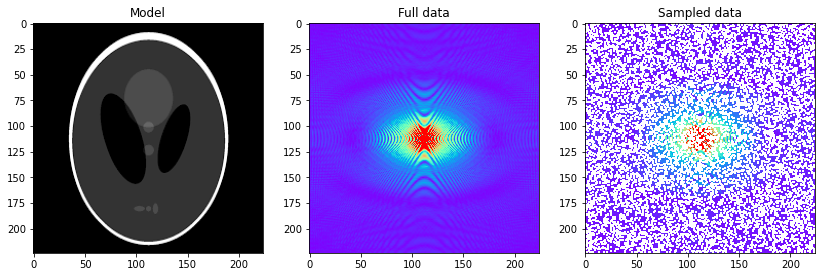

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(xtrue,  cmap="gray")
axs[0].set_title("Model")

axs[1].imshow(np.abs(yfft), vmin=0, vmax=1, cmap="rainbow")
axs[1].set_title("Full data")

axs[2].imshow(np.abs(ymask), vmin=0, vmax=1, cmap="rainbow")
axs[2].set_title("Sampled data")


In [17]:
Phi= lambda x: Rop * Fop * (x.ravel())
Phit = lambda x:  np.real(Fop.H * Rop.H * x) 

In [18]:
test_adj = True
if test_adj is True:
    print('Test adjointness of operator')
    xtmp = np.random.rand(*xtrue.shape)
    print(xtmp.shape)
    Phixtmp = Phi(xtmp)
    ytmp = np.random.rand(*Phixtmp.shape)
    Phitytmp = Phit(ytmp)
    print('x shape: ', xtmp.shape)
    print('y shape: ', ytmp.shape)
    print('Phi(x) shape: ', Phixtmp.shape)
    print('Phit(y) shape: ', Phitytmp.shape)
    fwd = np.real(np.sum(xtmp.flatten()*Phitytmp.flatten()))
    bwd = np.real(np.sum(Phixtmp.flatten()*ytmp.flatten()))
    print('forward: ', fwd)
    print('backward: ', bwd)
    print('-----------------------------')

Test adjointness of operator
(224, 224)
x shape:  (224, 224)
y shape:  (40141,)
Phi(x) shape:  (40141,)
Phit(y) shape:  (50176,)
forward:  87.23224026081621
backward:  87.23224026081621
-----------------------------


### 3.3 - Degraded data

In this section we now create a blurry and noisy image of the form:
$$
z = \Phi \overline{x} + \epsilon
$$
where $\epsilon\sim \mathcal{N}(0,\sigma^2\mathbb{I})$.
You can evalute the impact of the choice of the variance of the noise $\sigma^2$ by changing the value "std".

Text(0.5, 1.0, '$real(\\phi^*z)$')

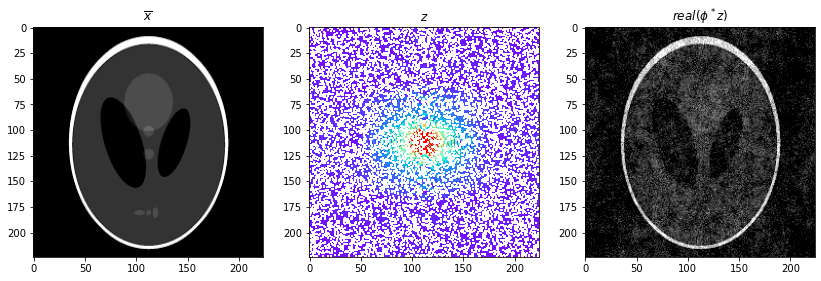

In [19]:
x_irm = Phi(xtrue)
nxb = x_irm.shape
std = 0.5
z = x_irm + std* np.random.rand(*x_irm.shape) 

xrec =  Phit(z)
#xrec = xrec.reshape(nx, ny)


fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(xtrue,  cmap="gray")
axs[0].set_title("$\overline{x}$")

axs[1].imshow(np.abs(ymask), vmin=0, vmax=1, cmap="rainbow")
axs[1].set_title("$z$")

axs[2].imshow((xrec.reshape(nx,ny)), vmin=0, vmax=1,  cmap="gray")
axs[2].set_title("$real(\phi^*z)$")
